In [ ]:
!unzip /content/drive/MyDrive/GTSRB.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from PIL import Image
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
IMG_SIZE=224
NUM_CLASSES=43

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "GTSRB",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32)    

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "GTSRB",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 197
Number of test batches: 49


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:

img_augmentation = Sequential(
    [
          preprocessing.RandomRotation(factor=0.2),
        preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        #preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224, 224) + (3,)
#base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')
base_model = EfficientNetB0(include_top=False, weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 43)


In [ ]:
  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_learning_rate = 0.001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [ ]:
initial_epochs = 14

loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
checkpoint1=tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Bosch_PS_weights/weights_resnet1.hdf5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
    
)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=[checkpoint1],
                    validation_data=validation_dataset)

Epoch 1/14
981/981 [==============================] - 83s 79ms/step - loss: 2.0071 - accuracy: 0.4437 - val_loss: 1.0008 - val_accuracy: 0.7156
Epoch 2/14
981/981 [==============================] - 77s 78ms/step - loss: 1.0225 - accuracy: 0.6990 - val_loss: 0.7716 - val_accuracy: 0.7755
Epoch 3/14
981/981 [==============================] - 77s 78ms/step - loss: 0.8531 - accuracy: 0.7412 - val_loss: 0.6586 - val_accuracy: 0.8014
Epoch 4/14
981/981 [==============================] - 77s 78ms/step - loss: 0.7532 - accuracy: 0.7712 - val_loss: 0.5986 - val_accuracy: 0.8219
Epoch 5/14
981/981 [==============================] - 77s 78ms/step - loss: 0.7038 - accuracy: 0.7815 - val_loss: 0.5523 - val_accuracy: 0.8356
Epoch 6/14
981/981 [==============================] - 77s 78ms/step - loss: 0.6732 - accuracy: 0.7884 - val_loss: 0.5042 - val_accuracy: 0.8530
Epoch 7/14
981/981 [==============================] - 77s 78ms/step - loss: 0.6418 - accuracy: 0.7927 - val_loss: 0.4796 - val_accuracy:

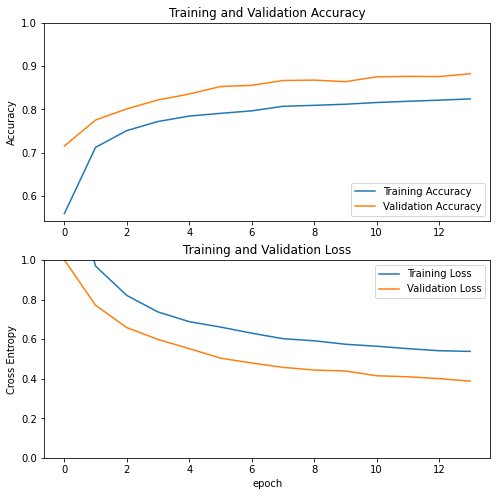

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  237


In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                55083     
Total params: 4,104,654
Trainable params: 3,342,787
Non-trainable params: 761,867
___________________________________________

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

checkpoint2=tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Bosch_PS_weights/weights_resnet.hdf5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
    
)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         callbacks=[checkpoint2],
                         initial_epoch=15,
                         validation_data=validation_dataset)

Epoch 16/29
981/981 [==============================] - 119s 115ms/step - loss: 0.2319 - accuracy: 0.9210 - val_loss: 0.0675 - val_accuracy: 0.9774
Epoch 17/29
981/981 [==============================] - 112s 114ms/step - loss: 0.1004 - accuracy: 0.9654 - val_loss: 0.0549 - val_accuracy: 0.9809
Epoch 18/29
981/981 [==============================] - 112s 114ms/step - loss: 0.0645 - accuracy: 0.9774 - val_loss: 0.0437 - val_accuracy: 0.9844
Epoch 19/29
981/981 [==============================] - 112s 114ms/step - loss: 0.0487 - accuracy: 0.9839 - val_loss: 0.0231 - val_accuracy: 0.9936
Epoch 20/29
981/981 [==============================] - 112s 114ms/step - loss: 0.0375 - accuracy: 0.9875 - val_loss: 0.0243 - val_accuracy: 0.9923
Epoch 21/29
981/981 [==============================] - 112s 114ms/step - loss: 0.0287 - accuracy: 0.9897 - val_loss: 0.0242 - val_accuracy: 0.9922
Epoch 22/29
981/981 [==============================] - 112s 114ms/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0

KeyboardInterrupt: ignored